# 概要

遺伝子でない特徴量と遺伝子特徴量を組み合わせてEDAを行う

In [1]:
import os
import random
import itertools

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# 特徴量選択
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    VarianceThreshold,
    RFE,
    RFECV,
)


# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

/Users/masanari/Library/CloudStorage/OneDrive-東京理科大学/projects/breast_cancer_analytics/notebooks/functions.py:275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


# データ読み込み

## 臨床データの読み込み

先に1.0-EDA_clinicalを実行すること

In [2]:
df_clinical = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_clinical.pkl")
df_MB = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MTST = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MTST.pkl")

## 遺伝子データの読み込み

In [3]:
# cnaデータ
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T.sort_index()

# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()

# 　ファイルの中身が壊れているため、使用するなら要修正
# df_mutations = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_mutations.txt").T


# 各dfの中身変更防止の為setを仕様
df_set = (
    df_cna,
    df_methylation_promoters_rrbs,
    df_mrna_agilent_microarray_zscores_ref_all_samples,
    df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    df_mrna_agilent_microarray,
    # df_mutations
)
df_name_set = (
    "df_cna",
    "df_methylation_promoters_rrbs",
    "df_mrna_agilent_microarray_zscores_ref_all_samples",
    "df_mrna_agilent_microarray",
    # "df_mutations"
)

# 目的変数の生成

元のdfにはない目的変数カラム（5年後の生存の有無）を生成する。

## 目的変数｜5,10,15年後の予後の2値分類
5,10,15年後の予後を2値分類する。  
そのためにVITAL_STATUSとOS_MONTHを利用する。  
以下のフローチャートで生成する。  

In [4]:
HTML(
    '<div class="mxgraph" style="max-width:100%;border:1px solid transparent;" data-mxgraph="{&quot;highlight&quot;:&quot;#0000ff&quot;,&quot;nav&quot;:true,&quot;resize&quot;:true,&quot;toolbar&quot;:&quot;zoom layers tags lightbox&quot;,&quot;edit&quot;:&quot;_blank&quot;,&quot;xml&quot;:&quot;&lt;mxfile host=\&quot;Electron\&quot; modified=\&quot;2022-05-01T07:33:42.0.405Z\&quot; agent=\&quot;5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) draw.io/17.2.0.2 Chrome/100.0.4896.60 Electron/18.0.1 Safari/537.36\&quot; etag=\&quot;CUa6MuG2A-EYqdbBh0ys\&quot; version=\&quot;17.2.0.2\&quot; type=\&quot;device\&quot;&gt;&lt;diagram id=\&quot;C5RBs43oDa-KdzZeNtuy\&quot; name=\&quot;Page-1\&quot;&gt;7VhZc5swEP41TJ7a4Yix/RjbcZI2SduBJNOnjAIyqBasK4SP/vpKQTIQXB9tncMTP3jYZVlJ+317gOH0k/kZQ5P4CkJMDdsM54YzMGy7ZZniXyoWhcLtOoUiYiQsVFap8MgvrJTquSgnIc5qhhyAcjKpKwNIUxzwmg4xBrO62QhofdUJinBD4QWINrV3JORxoe3Y7VJ/jkkU65Utt1vcSZA2VifJYhTCrKJyTg2nzwB4cZXM+5jK2Om43F0s7ujl2D379C37iW56n/3r2w+Fs+EujyyPwHDK/69ru3A9RTRX8VJn5QsdQAZ5GmLpxDScXswTKi4tcfkDc75QgKOcg1AB4zFEkCJ6CTBRdiNIuTKzpIzT8EQCK+QHCsG4UA0JpWoNISn7jpAyzmC8xE46WAIhjSl6wLSHgnH0uNE+UGDiVgoplq5CQQZ1lnJzp6W2t2VsFQYZ5CzAa+xUcnDEIrzOn1vYyf1VeKqQO8OQYM4WwoBhijiZ1smMVE5ES7sSd3GhoN+BBk6DBuHIaPVuL/yTy3vPP/FvPMMWrs0v3v3Vl2v/3DNagzVMkSjNYsKxN0GP4ZqJ2lJnT5UV4uC9iKIsU5hugHw3yKaYcTxfG2R911WZrkpdR4mzsm5YuhjElZpxbO4JluMGLN9FKX1P0H9JUHfLBNX9a2OGKrJoYmydsMrTVyDiXKUJjEaZ2NhT6iwX/Hs2tRpsuoYGmTbj8abp9kJkau/GJevVc8ltcKnsDDITXJTIek+5jLm8b+raWi1cMSQPeba5V9QAlvQZooRQGaxzTKeYkwCt6CiIkigVQiCwxmw1c8SSJI2E5JaS/8hUUXz32Gna9U6zlKutxlzRajr7ajXt1ROAYrZs9maB4xDRDB9c63fsJ4B0X7r3d7ap1m+6Fj9769dldXPvt7as14o95kdH/GoEev3jQHer4fJ9HtgPw+xDmwj0Dit8qr8+qv5xNCCCLLYJI/E3IBlGGT56Hw3+OBrYqzrRs44GuhpWZwMmAnFoM8DT1/9j56VnAF0lNk9lPssPfyhzrP0BIsTyS25RE8vP4c7pbw==&lt;/diagram&gt;&lt;/mxfile&gt;&quot;}"></div><script type="text/javascript" src="https://viewer.diagrams.net/js/viewer-static.min.js"></script>'
)

In [5]:
def make_target(df: pd.DataFrame(), year: int = 5, drop=False):
    df = df.copy()  # 引数dfの更新を防ぐ（pythonの関数は参照渡し）
    target_name = "OS_" + str(year) + "years"
    df[target_name] = np.nan
    df[target_name] = df[target_name].mask(df["OS_MONTHS"] > year * 12, False)
    df[target_name] = df[target_name].mask(
        (df["OS_MONTHS"] <= year * 12) & (df["VITAL_STATUS"] == "Died of Disease"),
        True,
    )
    # targetを定義できなかったデータは除く
    if drop:
        df = df[df[target_name].notnull()]
    return df

In [6]:
df_MB = make_target(df_MB, year=5)
df_MB = make_target(df_MB, year=10)
df_MB = make_target(df_MB, year=15)
target_list = ["OS_5years", "OS_10years", "OS_15years"]

# データフレームの結合

臨床データと遺伝子データを結合する  
結合パターン
1. 臨床データと生の遺伝子発現データ
2. 臨床データとzスコア化した遺伝子発現データ
3. 臨床データとzスコア化（2倍体）した遺伝子発現データ


In [7]:
df_MB.head()

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,CLAUDIN_SUBTYPE,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,TUMOR_STAGE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,BREAST_SURGERY,OS_MONTHS,OS_STATUS,VITAL_STATUS,RFS_STATUS,RFS_MONTHS,OS_5years,OS_10years,OS_15years
0,MB-0000,10.0,6.044,NaN,1.0,Post,Female,4ER+,75.65,claudin-low,ER-/HER2-,Right,Ductal/NST,MB-0000,3.0,IDC,Negative,Primary,0.000000,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,22.0,2.0,NO,YES,YES,MASTECTOMY,140.500000,0:LIVING,Living,0:Not Recurred,138.65,False,False,NaN
1,MB-0002,0.0,4.020,High,1.0,Pre,Female,4ER+,43.19,LumA,ER+/HER2- High Prolif,Right,Ductal/NST,MB-0002,3.0,IDC,Positive,Primary,2.615035,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,10.0,1.0,NO,YES,YES,BREAST CONSERVING,84.633333,0:LIVING,Living,0:Not Recurred,83.52,False,NaN,NaN
2,MB-0005,1.0,4.030,High,1.0,Pre,Female,3,48.87,LumB,NaN,Right,Ductal/NST,MB-0005,2.0,IDC,Positive,Primary,2.615035,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,15.0,2.0,YES,YES,NO,MASTECTOMY,163.700000,1:DECEASED,Died of Disease,1:Recurred,151.28,False,False,True
3,MB-0006,3.0,4.050,Moderate,1.0,Pre,Female,9,47.68,LumB,NaN,Right,Mixed,MB-0006,2.0,MDLC,Positive,Primary,1.307518,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Positve,NEUTRAL,Positive,Negative,25.0,2.0,YES,YES,YES,MASTECTOMY,164.933333,0:LIVING,Living,0:Not Recurred,162.76,False,False,NaN
4,MB-0008,8.0,6.080,High,1.0,Post,Female,9,76.97,LumB,ER+/HER2- High Prolif,Right,Mixed,MB-0008,3.0,MDLC,Positive,Primary,2.615035,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Positve,NEUTRAL,Positive,Negative,40.0,2.0,YES,YES,YES,MASTECTOMY,41.366667,1:DECEASED,Died of Disease,1:Recurred,18.55,True,True,True


In [8]:
df_mrna_agilent_microarray.head()

Hugo_Symbol,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,CR749394,CD164,DB337918,MOBKL2A,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
MB-0000,9.738092,6.469688,5.457135,5.106495,5.652674,11.558869,8.340484,5.384699,5.648494,5.336235,5.468668,7.070649,5.477154,5.489805,5.318898,6.811309,5.440853,5.361170,5.823306,8.809831,6.790593,5.595347,6.141047,5.481023,6.499117,...,5.353135,5.198876,5.901473,5.610397,5.515762,5.213511,8.139151,10.232505,7.311327,9.677952,5.318426,5.635153,5.918239,5.295203,5.474224,5.329883,5.745324,7.021679,8.010657,5.299815,6.235804,5.349555,5.947404,5.615147,5.133576
MB-0002,9.013876,5.748717,5.699735,5.419119,5.611212,6.199492,8.341091,5.490558,5.789506,5.700974,5.495295,6.098949,5.589824,5.055598,5.489397,6.952007,5.545206,5.579463,6.341935,9.307305,6.132436,5.328097,6.400910,5.531249,7.178274,...,4.888335,5.615278,6.447777,5.950548,5.502117,5.124030,8.261487,10.186566,6.324112,8.895600,5.345262,6.281727,5.515844,5.442257,5.303871,5.384794,5.285060,7.612797,7.988643,5.194247,6.328059,5.469445,6.938685,5.231857,5.604560
MB-0005,7.963493,5.553056,5.472386,5.265556,5.793398,6.489781,8.862815,5.538854,5.566713,7.233671,5.537530,6.964546,5.255454,5.374815,5.668776,6.480061,5.790445,5.462634,5.807004,8.477327,5.572601,5.539776,8.575001,5.562090,6.469047,...,5.313808,5.508167,6.076896,5.747801,5.368297,5.371385,7.731911,9.954702,7.222594,8.972083,5.420388,5.404494,5.350242,5.368716,5.370394,5.336455,5.452393,6.619220,8.044471,5.306294,6.306927,5.362207,7.397672,5.372138,5.645597
MB-0006,8.177157,5.391160,5.529795,5.011812,5.807604,5.319779,8.693784,5.430685,5.539252,6.124384,6.657355,6.409554,5.289307,5.299305,5.112324,5.987913,5.393475,5.282728,5.985588,8.101386,5.808433,5.345124,9.164529,5.336013,6.487679,...,5.228991,5.324400,5.650472,5.579526,5.303998,5.351482,8.301195,10.088769,7.053031,8.664307,5.370416,5.480761,5.650978,5.295628,5.694697,5.663304,5.529928,6.966482,7.527300,5.197607,6.515638,5.309927,6.175716,5.586521,5.354582
MB-0008,8.050127,5.530582,5.303667,5.149618,5.934570,8.787583,8.055626,5.239388,5.646685,7.155642,5.878104,5.798117,5.297733,5.610297,5.141883,6.675580,6.598310,5.328773,6.200995,9.301414,6.182025,5.384272,5.904271,5.457066,6.426740,...,5.322069,5.136661,6.403137,5.904885,5.473140,5.460753,8.007261,11.244345,5.926732,8.141539,5.217030,5.442109,5.527755,5.192858,5.474929,5.799346,5.597297,6.942461,8.115359,5.254136,6.323751,5.518767,6.272568,5.204630,5.030636


In [9]:
df_MB.shape, df_mrna_agilent_microarray.shape

((1985, 39), (1904, 24368))

## データフレームの結合

In [10]:
df_cross = pd.merge(
    df_MB,
    df_mrna_agilent_microarray,
    left_on="PATIENT_ID",
    right_index=True,
    how="inner",
).reset_index(drop=True)
df_cross.tail()

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,CLAUDIN_SUBTYPE,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
1899,MB-7295,1.0,5.05,High,4.0,Pre,Female,3,43.10,LumA,ER+/HER2- Low Prolif,Right,Lobular,MB-7295,3.0,ILC,Positive,Primary,5.230071,Breast Cancer,Breast Invasive Lobular Carcinoma,Positve,NEUTRAL,Positive,Negative,...,5.394435,5.324246,6.132406,5.471503,5.372043,5.364380,8.455392,10.303605,6.686198,9.987552,5.354638,5.529167,5.722099,5.240904,5.521765,5.488675,5.461927,7.536208,8.314500,5.337300,6.278034,5.426899,6.923887,5.251896,5.168953
1900,MB-7296,1.0,5.04,High,4.0,Pre,Female,5,42.88,LumB,NaN,NaN,Ductal/NST,MB-7296,3.0,IDC,Negative,Primary,7.845106,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,GAIN,Positive,Positive,...,5.304696,5.396539,6.221306,5.315972,5.300309,5.268524,8.523291,11.353435,6.623708,8.441388,5.443857,5.644035,5.453321,5.171671,5.441341,5.375910,5.393811,7.709596,8.105717,5.397931,6.325456,5.217163,6.524268,5.505418,5.252479
1901,MB-7297,45.0,6.05,High,4.0,Post,Female,1,62.90,LumB,NaN,Left,Ductal/NST,MB-7297,3.0,IDC,Positive,Primary,5.230071,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,...,5.466731,5.291783,7.066555,5.382979,5.550651,5.335161,8.286103,10.428968,6.769603,6.564861,5.591439,5.597712,5.334787,5.182920,5.339665,5.487068,5.406575,7.729912,7.944622,5.412713,6.254337,5.405552,6.121864,5.462270,5.357823
1902,MB-7298,12.0,5.05,Moderate,4.0,Post,Female,1,61.16,LumB,ER+/HER2- High Prolif,NaN,Ductal/NST,MB-7298,2.0,IDC,Positive,Primary,19.612766,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,...,5.294014,5.389626,6.250953,5.489047,5.725481,5.382300,8.473675,10.452393,6.571327,7.323750,5.334621,5.560818,5.406241,5.351516,5.361063,5.214711,5.689935,7.329023,8.348807,5.474224,6.415853,5.344851,7.029076,5.519022,5.512290
1903,MB-7299,1.0,5.04,High,4.0,Post,Female,10,60.02,LumB,ER+/HER2- High Prolif,NaN,Ductal/NST,MB-7299,3.0,IDC,Negative,Primary,3.922553,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,...,5.281974,5.253435,6.125892,5.466416,5.467026,5.384024,8.202645,10.394254,6.886155,8.423223,5.312663,5.772291,5.646755,5.479193,5.709304,5.227597,5.382574,7.763496,8.053959,5.238813,6.898575,5.353198,6.769960,5.464610,5.232599


In [11]:
# 重複カラムの有無の確認
df_cross.shape, df_cross.columns.duplicated().sum()

((1904, 24407), 192)

In [12]:
df_cross.shape

(1904, 24407)

### 重複カラムの確認
サンプルの重複はなかった  
カラムの重複はあった

In [13]:
# 重複数、重複した遺伝子発現名、各重複数
df_cross.columns[df_cross.columns.duplicated()].unique, df_cross.columns[
    df_cross.columns.duplicated()
].value_counts().sort_values()[::-1]

(<bound method Index.unique of Index(['RPAIN', 'LINC00937', 'SLC25A37', 'RPL36', 'PPM1H', 'DMRTC1B', 'CEP164',
        'RPL13A', 'RDH5', 'WASH3P',
        ...
        'CELF2', 'DEPDC4', 'SPAG8', 'KCTD5', 'TMEM35B', 'SMG1', 'SMAD5',
        'WASH3P', 'ZNF20', 'C4orf50'],
       dtype='object', length=192)>,
 TRDV2       6
 RPL13A      5
 IL23A       4
 WASH3P      3
 TMEM191C    2
            ..
 NNT         1
 BIRC5       1
 IL17RC      1
 HYDIN2      1
 GTF2H2      1
 Length: 168, dtype: int64)

In [14]:
"""
df_cross.columns[df_cross.columns.duplicated()].value_counts().sort_values()[
    ::-1
].to_csv("重複している遺伝子発現とその余剰数.csv")
"""
pass

### 重複カラムのリネーム
有識者の意見：重複した遺伝子発現は別の遺伝子発現として扱うべき。


In [15]:
# 重複特徴量のrename
df_cross = rename_duplicated_columns(df_cross)

In [16]:
# null値の確認
df_tmp = df_cross.isnull().sum()
display(
    df_tmp[df_tmp.values > 1].sort_values()[::-1]
)  # .sort_values()[::-1]の部分は表示で理解しやすいようにソートしているだけ
columns_tmp = df_tmp[df_tmp.values > 1].sort_values()[::-1].index  # 欠損値をかかえる特徴量名

OS_15years              826
TUMOR_STAGE             501
OS_10years              495
THREEGENE               204
OS_5years               147
LATERALITY              106
GRADE                    72
CELLULARITY              54
ER_IHC                   30
BREAST_SURGERY           22
TUMOR_SIZE               20
HISTOLOGICAL_SUBTYPE     15
CSNK2A1                   2
SLC25A19                  2
dtype: int64

遺伝子データの欠損は、以下の2つの特徴量のみ。
- CSNK2A1
- SLC25A19  

これらのデータが臨床データ側でも欠損があるなら安心して削除できる

In [17]:
df_cross[df_cross["CSNK2A1"].isnull()][columns_tmp]

,OS_15years,TUMOR_STAGE,OS_10years,THREEGENE,OS_5years,LATERALITY,GRADE,CELLULARITY,ER_IHC,BREAST_SURGERY,TUMOR_SIZE,HISTOLOGICAL_SUBTYPE,CSNK2A1,SLC25A19
718,False,1.0,False,ER+/HER2- High Prolif,False,Right,3.0,High,Positve,BREAST CONSERVING,15.0,Ductal/NST,NaN,7.055087
1658,NaN,NaN,NaN,ER+/HER2- High Prolif,False,Right,3.0,High,Negative,BREAST CONSERVING,23.0,Ductal/NST,NaN,7.260435


In [18]:
df_cross[df_cross["SLC25A19"].isnull()][columns_tmp]

,OS_15years,TUMOR_STAGE,OS_10years,THREEGENE,OS_5years,LATERALITY,GRADE,CELLULARITY,ER_IHC,BREAST_SURGERY,TUMOR_SIZE,HISTOLOGICAL_SUBTYPE,CSNK2A1,SLC25A19
486,False,2.0,False,ER+/HER2- Low Prolif,False,Left,1.0,Low,Positve,MASTECTOMY,25.0,Mixed,7.112496,NaN
1651,NaN,NaN,False,HER2+,False,Left,2.0,High,Positve,BREAST CONSERVING,14.0,Mucinous,8.069178,NaN


臨床データの欠損値はないようなので、サンプルデータの削除はしたくない・・・

その他の欠損値を持つサンプルの総数の確認

In [19]:
# 目的変数込での欠損値を含むサンプル数
df_cross[df_cross[columns_tmp].isnull().any(axis=1)][columns_tmp].shape

(1240, 14)

In [20]:
# 目的変数を除いた場合
columns_tmp = [
    "TUMOR_STAGE",
    "THREEGENE",
    "LATERALITY",
    "GRADE",
    "CELLULARITY",
    "ER_IHC",
    "BREAST_SURGERY",
    "TUMOR_SIZE",
    "HISTOLOGICAL_SUBTYPE",
    "CSNK2A1",
    "SLC25A19",
]
df_cross[df_cross[columns_tmp].isnull().any(axis=1)][columns_tmp].shape

(781, 11)

## 遺伝子発現データと組み合わせる臨床データ

遺伝子発現データと組み合わせる際、必要となる臨床データは免疫組織学的特徴量と遺伝子的特徴量の2種であり、それらの有無は以下の特徴量に示される。

**免疫組織学特徴量**
- ER_STATUS
- PR_STATUS
- HER2_STATUS

**遺伝子学的特徴量**
- CLAUDIN_SUBTYPE

In [21]:
# 学術的知見に基づくクラス分類
immune_study_columns = ["ER_STATUS", "PR_STATUS", "HER2_STATUS"]
gene_study_columns = ["CLAUDIN_SUBTYPE"]

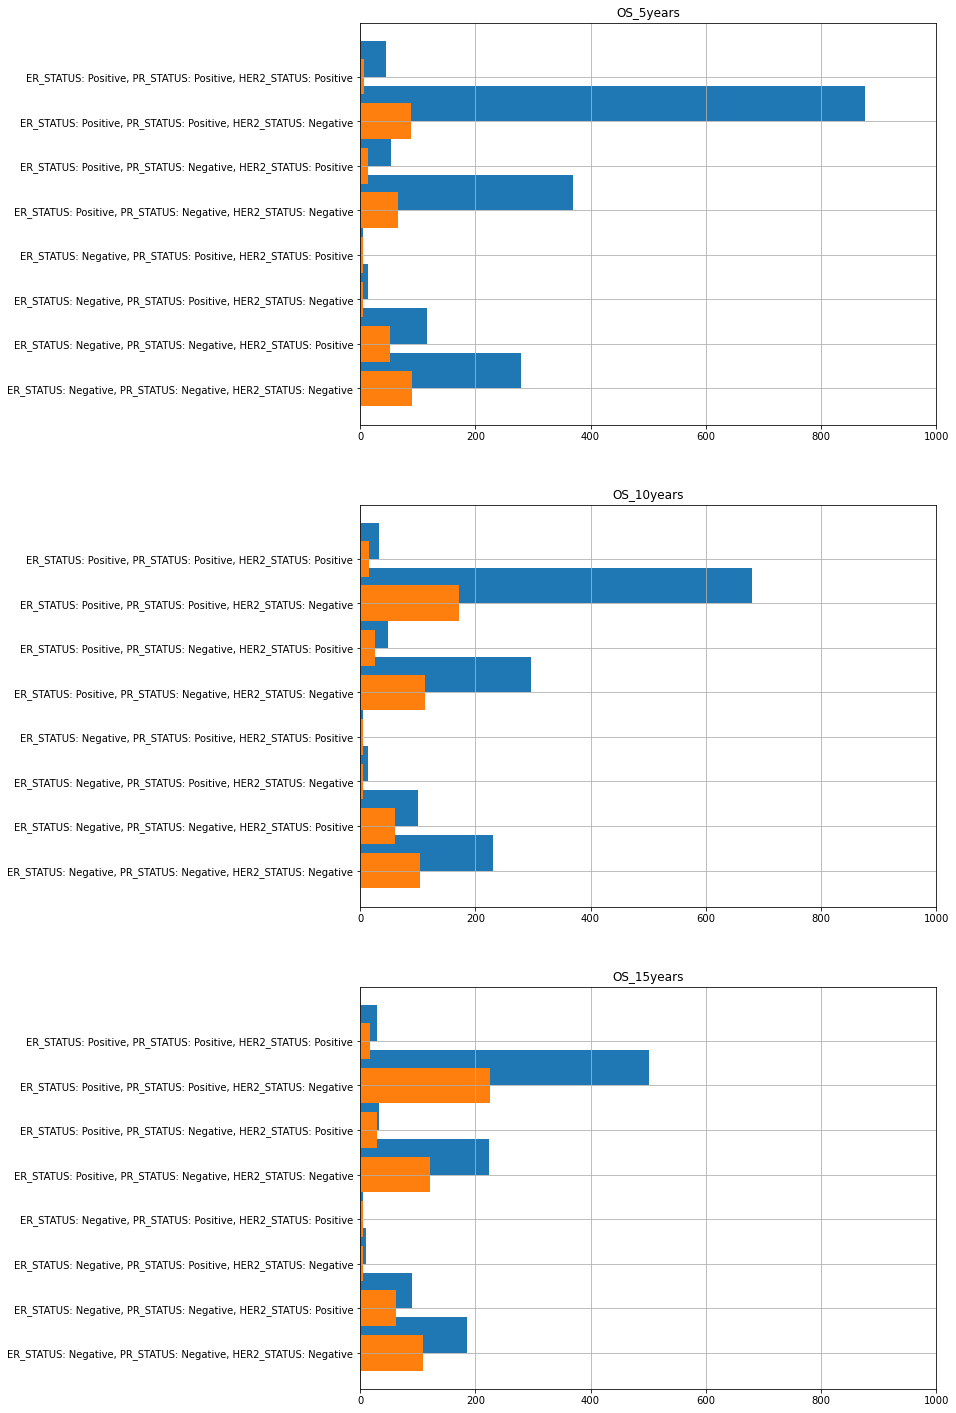

In [22]:
plt.figure(figsize=(20, 34))
plt.subplots_adjust(left=0.5)
funcs = ["count", "sum", "mean"]
for i, v in enumerate(target_list):
    # 各STATUSに属するサンプル数の可視化
    # df_tmp: 表示したい数のdf、df_tmp2: プロット時のクラス名前の付与
    df_tmp = df_cross.groupby(immune_study_columns)[v].agg(funcs).reset_index()
    df_tmp["immune_label"] = (
        immune_study_columns[0]
        + ": "
        + df_tmp[immune_study_columns[0]]
        + ", "
        + immune_study_columns[1]
        + ": "
        + df_tmp[immune_study_columns[1]]
        + ", "
        + immune_study_columns[2]
        + ": "
        + df_tmp[immune_study_columns[2]]
    )
    plt.subplot(len(target_list) + 1, 1, i + 1)

    plt.barh(y=df_tmp["immune_label"], width=df_tmp["count"], align="edge")
    plt.title(v)
    plt.tight_layout = True

    # 各STAUSに属する目的変数の正例（乳がんによってn年の予後の死亡者数）の可視化
    # sumのカラムを指定しているが、これは目的変数が2値分類であるため、sumがtrueの総数を示している。
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["immune_label"], width=df_tmp["sum"])
    plt.title(v)
    plt.tight_layout = True
    plt.xlim(0, 1000)

    plt.grid(True)
make_dir(config.FIGURES_PROGNOSIS_CROSS_DIR)
plt.savefig(config.FIGURES_PROGNOSIS_CROSS_DIR + "/OS_immune_clf.png")

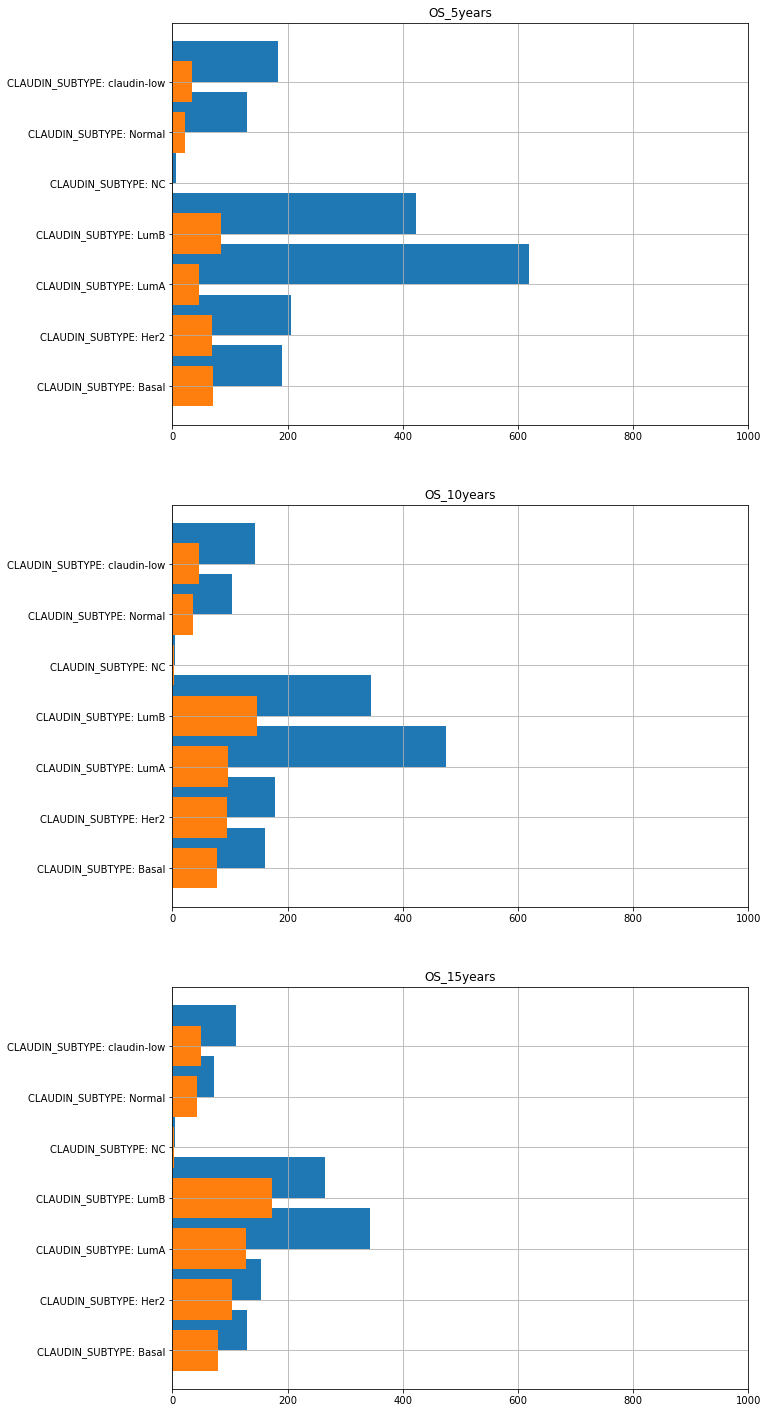

In [23]:
plt.figure(figsize=(20, 34))
plt.subplots_adjust(left=0.5)
funcs = ["count", "sum", "mean"]
for i, v in enumerate(target_list):
    # 各STATUSに属するサンプル数の可視化
    # df_tmp: 表示したい数のdf、df_tmp2: プロット時のクラス名前の付与
    df_tmp = df_cross.groupby(gene_study_columns)[v].agg(funcs).reset_index()
    df_tmp["gene_label"] = gene_study_columns[0] + ": " + df_tmp[gene_study_columns[0]]
    plt.subplot(len(target_list) + 1, 1, i + 1)

    plt.barh(y=df_tmp["gene_label"], width=df_tmp["count"], align="edge")
    plt.title(v)
    plt.tight_layout = True

    # 各STAUSに属する目的変数の正例（乳がんによってn年の予後の死亡者数）の可視化
    # sumのカラムを指定しているが、これは目的変数が2値分類であるため、sumがtrueの総数を示している。
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["sum"])
    plt.title(v)
    plt.tight_layout = True
    plt.xlim(0, 1000)

    plt.grid(True)
make_dir(config.FIGURES_PROGNOSIS_CROSS_DIR)
plt.savefig(config.FIGURES_PROGNOSIS_CROSS_DIR + "/OS_gene_clf.png")

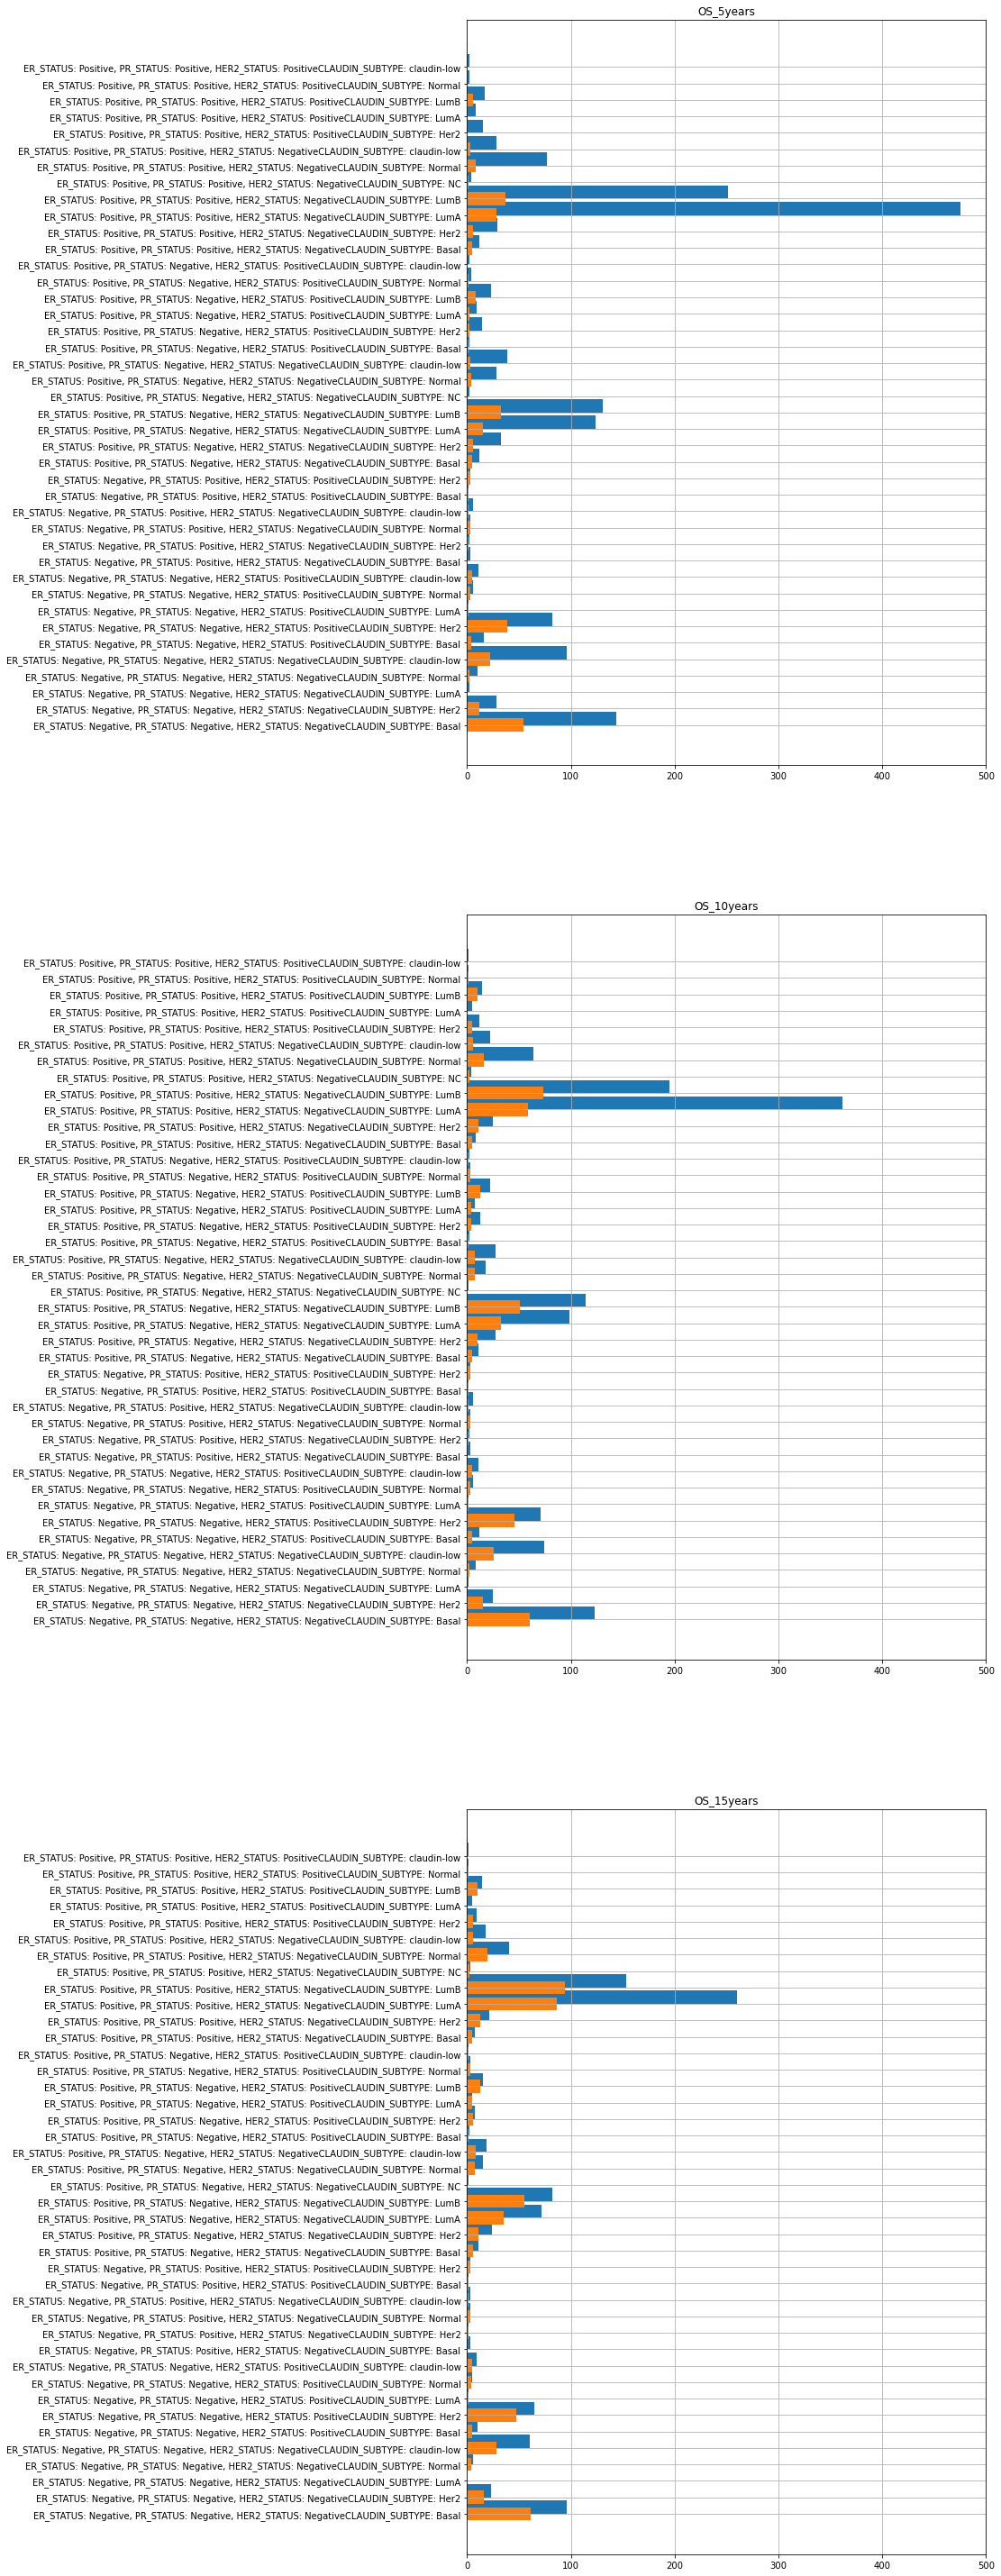

In [24]:
plt.figure(figsize=(20, 70))
plt.subplots_adjust(left=0.5)
funcs = ["count", "sum", "mean"]
for i, v in enumerate(target_list):
    # 各STATUSに属するサンプル数の可視化
    # df_tmp: 表示したい数のdf、df_tmp2: プロット時のクラス名前の付与
    df_tmp = (
        df_cross.groupby(immune_study_columns + gene_study_columns)[v]
        .agg(funcs)
        .reset_index()
    )
    df_tmp["cross_label"] = (
        immune_study_columns[0]
        + ": "
        + df_tmp[immune_study_columns[0]]
        + ", "
        + immune_study_columns[1]
        + ": "
        + df_tmp[immune_study_columns[1]]
        + ", "
        + immune_study_columns[2]
        + ": "
        + df_tmp[immune_study_columns[2]]
        + gene_study_columns[0]
        + ": "
        + df_tmp[gene_study_columns[0]]
    )
    plt.subplot(len(target_list) + 1, 1, i + 1)

    plt.barh(y=df_tmp["cross_label"], width=df_tmp["count"], align="edge")
    plt.title(v)
    plt.tight_layout = True

    # 各STAUSに属する目的変数の正例（乳がんによってn年の予後の死亡者数）の可視化
    # sumのカラムを指定しているが、これは目的変数が2値分類であるため、sumがtrueの総数を示している。
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["cross_label"], width=df_tmp["sum"])
    plt.title(v)
    plt.tight_layout = True
    plt.xlim(0, 500)

    plt.grid(True)

make_dir(config.FIGURES_PROGNOSIS_CROSS_DIR)
plt.savefig(config.FIGURES_PROGNOSIS_CROSS_DIR + "/OS_cross_clf.png")

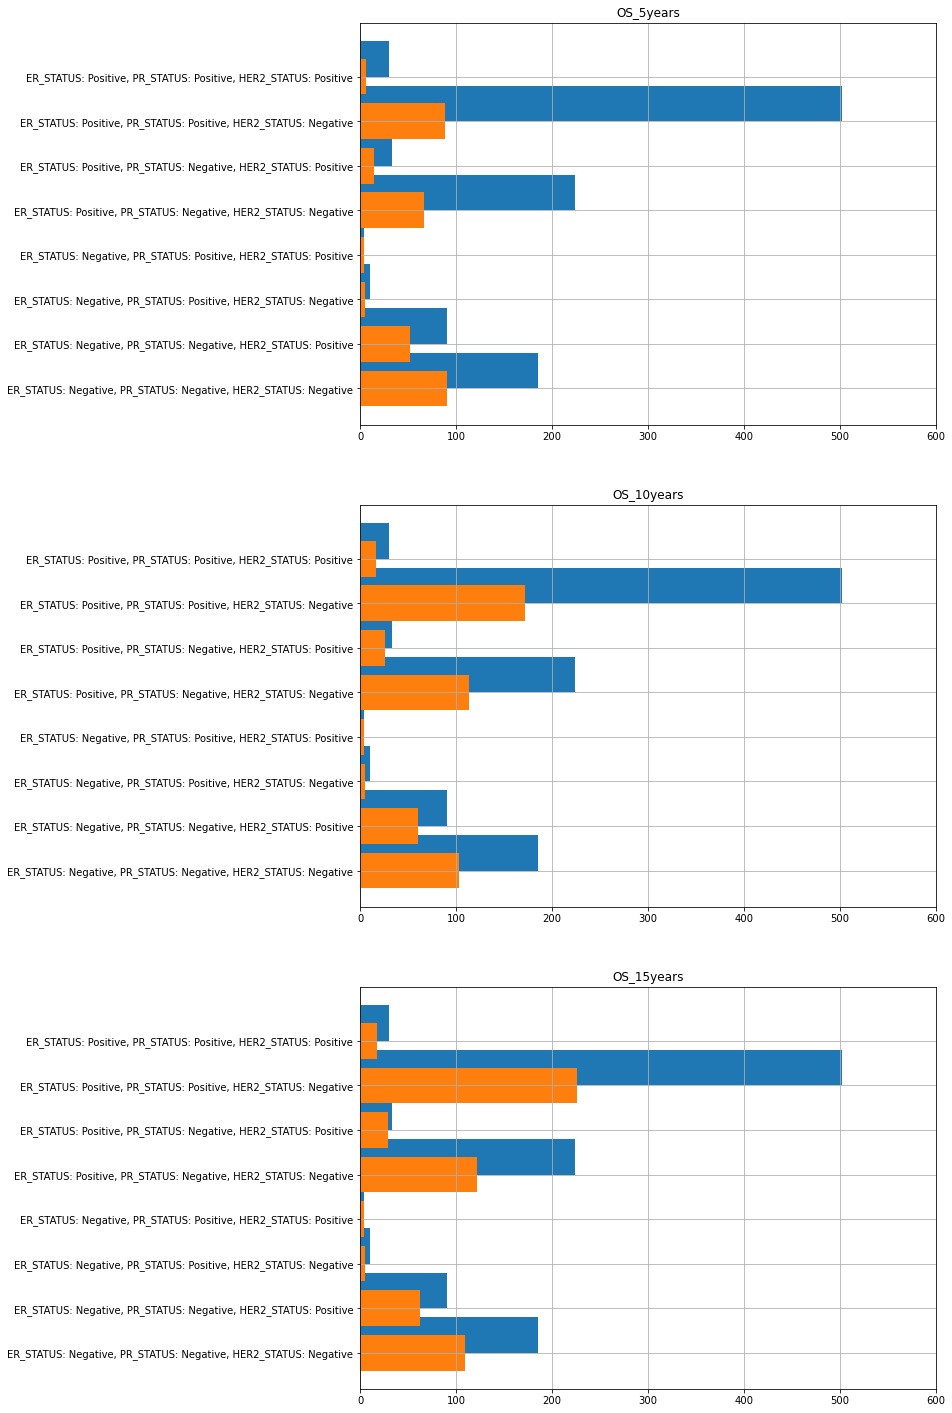

In [25]:
# OS_15yearsまで埋まっているデータの比較
df_tmp2 = df_cross[df_cross["OS_15years"].notnull()]

plt.figure(figsize=(20, 34))
plt.subplots_adjust(left=0.5)
funcs = ["count", "sum", "mean"]
for i, v in enumerate(target_list):
    # 各STATUSに属するサンプル数の可視化
    # df_tmp: 表示したい数のdf、df_tmp2: プロット時のクラス名前の付与
    df_tmp = df_tmp2.groupby(immune_study_columns)[v].agg(funcs).reset_index()
    df_tmp["immune_label"] = (
        immune_study_columns[0]
        + ": "
        + df_tmp[immune_study_columns[0]]
        + ", "
        + immune_study_columns[1]
        + ": "
        + df_tmp[immune_study_columns[1]]
        + ", "
        + immune_study_columns[2]
        + ": "
        + df_tmp[immune_study_columns[2]]
    )
    plt.subplot(len(target_list) + 1, 1, i + 1)

    plt.barh(y=df_tmp["immune_label"], width=df_tmp["count"], align="edge")
    plt.title(v)
    plt.tight_layout = True

    # 各STAUSに属する目的変数の正例（乳がんによってn年の予後の死亡者数）の可視化
    # sumのカラムを指定しているが、これは目的変数が2値分類であるため、sumがtrueの総数を示している。
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["immune_label"], width=df_tmp["sum"])
    plt.title(v)
    plt.tight_layout = True
    plt.xlim(0, 600)

    plt.grid(True)
make_dir(config.FIGURES_PROGNOSIS_CROSS_DIR)
plt.savefig(config.FIGURES_PROGNOSIS_CROSS_DIR + "/OS_immune_clf2.png")

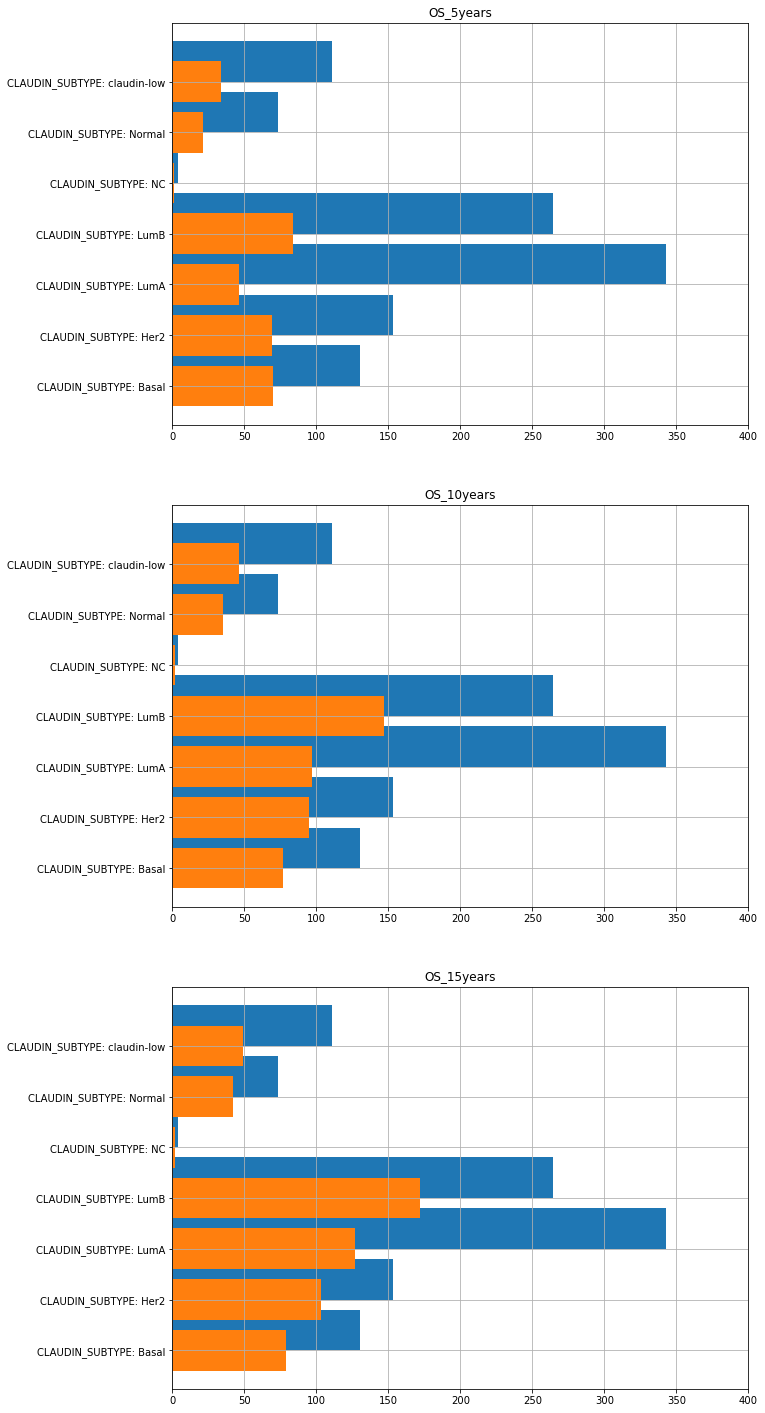

In [26]:
df_tmp2 = df_cross[df_cross["OS_15years"].notnull()]
plt.figure(figsize=(20, 34))
plt.subplots_adjust(left=0.5)
funcs = ["count", "sum", "mean"]
for i, v in enumerate(target_list):
    # 各STATUSに属するサンプル数の可視化
    # df_tmp: 表示したい数のdf、df_tmp2: プロット時のクラス名前の付与
    df_tmp = df_tmp2.groupby(gene_study_columns)[v].agg(funcs).reset_index()
    df_tmp["gene_label"] = gene_study_columns[0] + ": " + df_tmp[gene_study_columns[0]]
    plt.subplot(len(target_list) + 1, 1, i + 1)

    plt.barh(y=df_tmp["gene_label"], width=df_tmp["count"], align="edge")
    plt.title(v)
    plt.tight_layout = True

    # 各STAUSに属する目的変数の正例（乳がんによってn年の予後の死亡者数）の可視化
    # sumのカラムを指定しているが、これは目的変数が2値分類であるため、sumがtrueの総数を示している。
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["sum"])
    plt.title(v)
    plt.tight_layout = True
    plt.xlim(0, 400)

    plt.grid(True)
make_dir(config.FIGURES_PROGNOSIS_CROSS_DIR)
plt.savefig(config.FIGURES_PROGNOSIS_CROSS_DIR + "/OS_gene_clf2.png")